In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
import math
import torch.optim as optim
from IPython import display
import itertools
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# MNIST Dataset 
dataset = dsets.FashionMNIST(root='./data', train=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]),  download=True)
testset = dsets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]),  download=True)

# Data Loader (Input Pipeline)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=100, shuffle=True)

26427392it [00:02, 12961746.74it/s]                              


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 91921.40it/s]                            
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4039899.10it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 31494.47it/s]            

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def to_np(x):
    return x.data.cpu().numpy()

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x) 

def to_cuda(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [0]:
#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 512)
        #self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        #x = self.lin3gauss(x)
        return x

# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(512, 512)
        self.lin2 = nn.Linear(512, 512)
        self.lin3 = nn.Linear(512, 784)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.4, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.4, training=self.training)
        x = self.lin3(x)
        return F.sigmoid(x)

# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 1)
    def forward(self, x):
        x = F.dropout(self.lin1(x), p=0.2, training=self.training)
        x = F.relu(x)
        x = F.dropout(self.lin2(x), p=0.2, training=self.training)
        x = F.relu(x)
        return F.sigmoid(self.lin3(x))

In [0]:
z_red_dims = 512
Q = to_cuda(Q_net(784,512,z_red_dims))
P = to_cuda(P_net(784,512,z_red_dims))
D_gauss = to_cuda(D_net_gauss(500,z_red_dims))


# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

#encode/decode optimizers
optim_P = optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = optim.Adam(D_gauss.parameters(), lr=reg_lr)

In [0]:
num_test_samples = 100

test_noise = torch.randn(num_test_samples,z_red_dims)
test_noise = to_var(test_noise)

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Using a target size (torch.Size([100, 1, 28, 28])) that is different to the input size (torch.Size([100, 784])) is deprecated. Please ensure they have the same size.


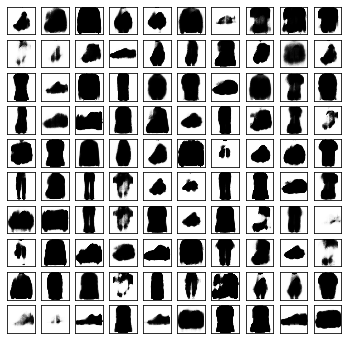

In [41]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)
    
    
data_iter = iter(data_loader)
iter_per_epoch = len(data_loader)
total_step = 1

# Start training
for step in range(total_step):
    print(step)
    # Reset the data_iter
    if (step+1) % iter_per_epoch == 0:
        data_iter = iter(data_loader)

    # Fetch the images and labels and convert them to variables
    images, labels = next(data_iter)
    images, labels = to_var(images),to_var(labels)
    #images, labels = to_var(images.view(images.size(0), -1)), to_var(labels)

    #reconstruction loss
    P.zero_grad()
    Q.zero_grad()
    D_gauss.zero_grad()

    z_sample = Q(images)   #encode to z
    X_sample = P(z_sample) #decode to X reconstruction
    recon_loss = F.binary_cross_entropy(X_sample,images)

    recon_loss.backward()
    optim_P.step()
    optim_Q_enc.step()

    # Discriminator
    ## true prior is random normal (randn)
    ## this is constraining the Z-projection to be normal!
    Q.eval()
    z_real_gauss = to_var(torch.randn(images.size()[0], z_red_dims))
    D_real_gauss = D_gauss(z_real_gauss)

    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)

    D_loss = -torch.mean(torch.log(D_real_gauss) + torch.log(1 - D_fake_gauss))

    D_loss.backward()
    optim_D.step()

    # Generator
    Q.train()
    z_fake_gauss = Q(images)
    D_fake_gauss = D_gauss(z_fake_gauss)
    
    G_loss = -torch.mean(torch.log(D_fake_gauss))

    G_loss.backward()
    optim_Q_gen.step()   
    
    P.eval()
    test_images = P(test_noise)
    P.train()
            
    for k in range(num_test_samples):
        i = k//10
        j = k%10
        ax[i,j].cla()
        ax[i,j].imshow(to_np(test_images[k,:]).reshape(28, 28), cmap='Greys')
    #display.clear_output(wait=True)
    #display.display(plt.gcf())

In [0]:
#Encoder
class Classifier(nn.Module):  
    def __init__(self):
        super(Classifier, self).__init__()
        self.l1 = Q
        self.l2 = nn.Linear(512,10)
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

      

In [37]:
net = to_cuda(Classifier())
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.002)

Classifier(
  (l1): Q_net(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=512, bias=True)
  )
  (l2): Linear(in_features=512, out_features=10, bias=True)
)


In [38]:
iterations = 100

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    for i, data in enumerate(data_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels =to_var(inputs), to_var(labels)
        #inputs, labels = to_var(inputs.view(inputs.size(0), -1)), to_var(labels)
        
        net.train()
        optimizer.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        
    correct = 0
    total = 0
    for data in data_loader:
        net.eval()
        inputs, labels = data
        inputs, labels =to_var(inputs), to_var(labels)
        #inputs, labels = to_var(inputs.view(inputs.size(0), -1)), to_var(labels)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    print('At Iteration : %d / %d  ;Train Accuracy : %.2f'%(epoch + 1,iterations,100 * float(correct) /float(total)))
        
        
        
    correct = 0
    total = 0
    for data in test_loader:
        net.eval()
        inputs, labels = data
        inputs, labels =to_var(inputs), to_var(labels)
        #inputs, labels = to_var(inputs.view(inputs.size(0), -1)), to_var(labels)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.data).sum()
    print('At Iteration : %d / %d  ;Test Accuracy : %.2f'%(epoch + 1,iterations,100 * float(correct) /float(total)))
print('Finished Training')

At Iteration : 1 / 100  ;Train Accuracy : 81.60
At Iteration : 1 / 100  ;Test Accuracy : 80.60
At Iteration : 2 / 100  ;Train Accuracy : 84.19
At Iteration : 2 / 100  ;Test Accuracy : 83.37
At Iteration : 3 / 100  ;Train Accuracy : 85.55
At Iteration : 3 / 100  ;Test Accuracy : 84.80
At Iteration : 4 / 100  ;Train Accuracy : 86.64
At Iteration : 4 / 100  ;Test Accuracy : 85.75
At Iteration : 5 / 100  ;Train Accuracy : 87.13
At Iteration : 5 / 100  ;Test Accuracy : 86.15
At Iteration : 6 / 100  ;Train Accuracy : 87.72
At Iteration : 6 / 100  ;Test Accuracy : 86.54
At Iteration : 7 / 100  ;Train Accuracy : 88.47
At Iteration : 7 / 100  ;Test Accuracy : 87.31
At Iteration : 8 / 100  ;Train Accuracy : 88.94
At Iteration : 8 / 100  ;Test Accuracy : 87.63
At Iteration : 9 / 100  ;Train Accuracy : 88.78
At Iteration : 9 / 100  ;Test Accuracy : 87.49
At Iteration : 10 / 100  ;Train Accuracy : 89.13
At Iteration : 10 / 100  ;Test Accuracy : 87.77
At Iteration : 11 / 100  ;Train Accuracy : 89.55

In [39]:
# Save and load the entire model
#torch.save(net.state_dict(), './mnist_baseline.pkl')
from google.colab import drive
drive.mount('/content/gdrive')
colab='Colab Notebooks'
model_save_name = 'AAE_FashionMNIST_Arch2.pt'
path = F"/content/gdrive/My Drive/{colab}/{model_save_name}" 
torch.save(net.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
